# Introduction

In this notebook, I evaluate the order parameters for Bernal bilayer graphene (BBG). I calculate the order parameters within within mean field theory, and numerically solve the relevant self consistent field equations using an iterative approach. 

Once the order parameters have been solved, relevant physical observables, such as isospin occupation, are readily calculated and compared to experiment. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata

# Loading Experimental Data

I first load and plot the experimental data to be analyzed later. Here, I'll plot compressibility as a function of displacement field and number density. While I m not calculating compressibility, one can clearly see the phase transitions in this data, which can then be compared to the phase transitions computed in my code. This data come from [Zhou et al., Science 375, 774–778 (2022)](https://www.science.org/doi/10.1126/science.abm8386)

In [2]:
number_density = pd.read_excel('fig1_and_s3.xlsx',sheet_name='1e_n').to_numpy()
displacement = pd.read_excel('fig1_and_s3.xlsx',sheet_name='1e_D').to_numpy()
compressibility = pd.read_excel('fig1_and_s3.xlsx',sheet_name='1e_cp').to_numpy()

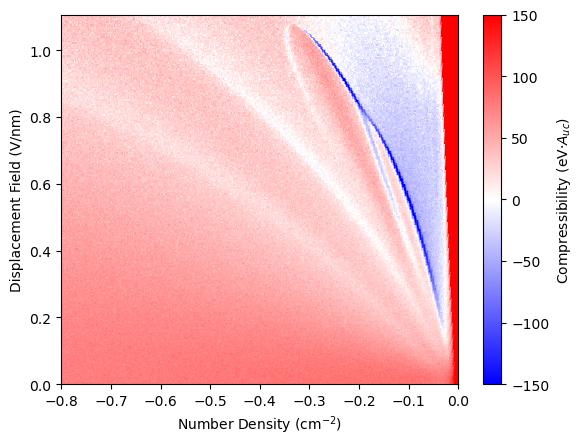

In [3]:
plt.colorbar(plt.pcolormesh(number_density,displacement,compressibility,vmin=-150,vmax=150,cmap='bwr'),label=r'Compressibility (eV$\cdot A_{uc}$)')
plt.xlim(-.8,0);
plt.ylim(0,np.max(displacement));
plt.xlabel(r'Number Density (cm$^{-2}$)');
plt.ylabel(r'Displacement Field (V/nm)');

Above, several white and dark blue lines can be seen - these correspond to the phase transitions in the material.

# Loading Results 

I load the results from the results of running the .py files. However, I need the momenta used in those files here as well, so I'll first define them the same way they are defined in solve_gap_refactored.py. 

In [4]:
L = 250*6
b1 = np.array([2*np.pi,2*np.pi/np.sqrt(3)]) #Recipricol lattice vector 1
b2 = np.array([2*np.pi,-2*np.pi/np.sqrt(3)]) #Recipricol lattice vector 2
momenta = np.array([(n1*b1+n2*b2)/L for n1 in range(-200,200) for n2 in range(-200,200) if np.linalg.norm((n1*b1+n2*b2)/L)<4*np.pi/3*.06])
kx = momenta[:,0]
ky = momenta[:,1]

I load the results here. I choose the values for the order parameter, chemical potential, and isospin occupation that correspond to the state with the lowest energy. I then delete the results for the order parameter in states that do not minimize the energy, as this variable is by far the largest (4-8 GB), and will slow down performance if it remains in memory.

In [5]:
directory = 'results/' #Directory that hosts the results

#Loading each of the relevant parameters
energy = np.load(directory+'normal_state_bands.npy')
d = np.load(directory+'delta.npy')
ef = np.load(directory+'ef.npy')
ef_norm = np.load(directory+'ef_norm.npy')
errors = np.load(directory+'error.npy')
occupation = np.load(directory+'occupation.npy')
energies = np.load(directory+'best_energies.npy')

#Getting shapes of the displacement field, momenta, and number density arrays
lengthv = d.shape[0]
lengthn = d.shape[1]
lengthm = d.shape[4]

total_number = np.linspace(1e10,10e11,lengthn)
v = np.linspace(25,200,lengthv)

#Getting the order parameter, chemical potential, and isospin occupations that minimize the energy of the system
true_d = np.zeros((lengthv,lengthn,4,lengthm));
true_ef = np.zeros((lengthv,lengthn))
true_occupation = np.zeros((lengthv,lengthn,4))
for j in range(lengthv):
    for i in range(lengthn):
        true_d[j,i] = d[j,i,np.argmin(energies,axis=0)[j,i]]
        true_ef[j,i] = ef[j,i,np.argmin(energies,axis=0)[j,i]]
        true_occupation[j,i] = occupation[j,i,np.argmin(energies,axis=0)[j,i]]
        
true_occupation = np.moveaxis(np.array([true_occupation[:,:,i]/np.sum(true_occupation,axis=-1) for i in range(4)]),0,2)

del d

## Isospin Occupation

Here, the occupation of the majority isospin for both displamement field and number density is plotted. Then as an example, I plot all four isospin occupations for specific displacement field. This demonstrates some of the order phases that will appear in the system. Comparing with the compressibility data, one can see the phase transitions have the same qualitative shape.

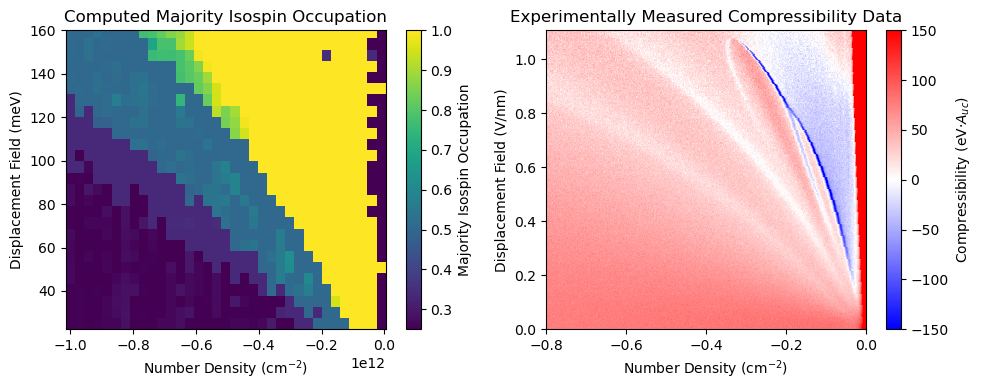

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plt.colorbar(ax1.pcolormesh(-total_number,v,np.sort(true_occupation)[:,:,-1]),label='Majority Isospin Occupation')
ax1.set_xlabel(r'Number Density (cm$^{-2}$)');
ax1.set_ylabel(r'Displacement Field (meV)');
lower, upper = ax1.get_ylim()
ax1.set_ylim(lower,160)   
ax1.set_title('Computed Majority Isospin Occupation')

plt.colorbar(ax2.pcolormesh(number_density,displacement,compressibility,vmin=-150,vmax=150,cmap='bwr'),label=r'Compressibility (eV$\cdot A_{uc}$)')
ax2.set_xlim(-.8,0);
ax2.set_ylim(0,np.max(displacement));
ax2.set_xlabel(r'Number Density (cm$^{-2}$)');
ax2.set_ylabel(r'Displacement Field (V/nm)');
ax2.set_title('Experimentally Measured Compressibility Data')

plt.tight_layout()
plt.show()

Below is the isospin occupation for all four isospins at a given displacement field. This indicates specifically what phases are predicted in the material at various number densities.

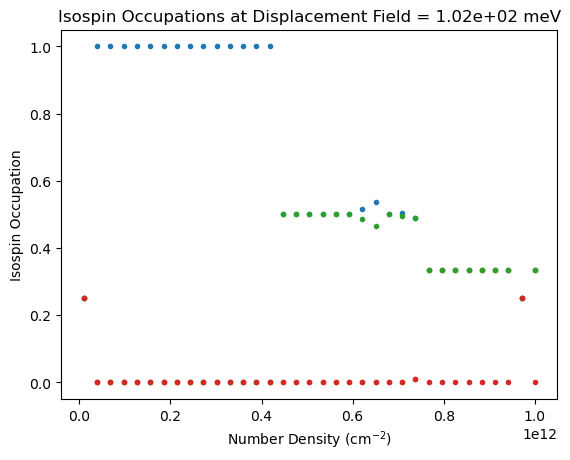

In [7]:
plt.plot(total_number,true_occupation[15],'.')
plt.title(f'Isospin Occupations at Displacement Field = {v[15]:.3} meV')
plt.xlabel(r'Number Density (cm$^{-2}$)');
plt.ylabel(r'Isospin Occupation');

## Unique Phases

Now, I want to determine the unique phases in this system. This is determined by what fraction of particles are in each isospin. I categorize this, then determine all unique combinations of isospin occupations that occur. Then where these phases occur can be plotted. 

In [8]:
#Categorizing the isospin occupation
dummy = np.where(true_occupation<.01,0,true_occupation)
dummy = np.where((true_occupation>.01) & (true_occupation<.24),1,dummy)
dummy = np.where((true_occupation>.23) & (true_occupation<.26),2,dummy)
dummy = np.where((true_occupation>.26) & (true_occupation<.35),3,dummy)
dummy = np.where((true_occupation>.35) & (true_occupation<.54),4,dummy)
dummy = np.where((true_occupation>.52),5,dummy)
dummy = np.sort(dummy,axis=-1)

dummy2 = np.zeros((dummy.shape[0],dummy.shape[1],6))

#Getting the unique phases
for i in range(dummy.shape[0]):
    for j in range(dummy.shape[1]):
        test = dummy[i,j]
        zerolen = len(test[test==0])
        nonzero_unique = np.unique(test)[np.unique(test)!=0]
        nonzerolen = len(nonzero_unique)
        degeneracy = np.zeros(4)
        for k in range(nonzerolen):
            degeneracy[k] = len(test[test==nonzero_unique[k]])
        dummy2[i,j] = np.array([zerolen,nonzerolen,degeneracy[0],degeneracy[1],degeneracy[2],degeneracy[3]])

unique_values = np.unique(dummy2.reshape(-1,6),axis=0)
labels = np.linspace(0,len(unique_values)-1,len(unique_values))

#Replacing the original labels (which were numpy arrays) with numbers
labeled_states = np.array([[labels[(unique_values==x).all(axis=1)][0] for x in y] for y in dummy2])

There are a total of 9 different states, labeled 0 through 8. These correspond to:


0: Full Metal (Normal State)

1: Partially Polarized Three Quarters Metal

2: Partially Polarized Half Metal (1 majority isospins, 3 minority isospins)

3: Partially Polarized Quarter Metal

4: Unevenly Partially Polarized Quarter Metal (1 majority isospin, 3 minority isospins with differing occupations)

5: Three Quarters Metal

6: Half Metal

7: Polarized Quarter Metal (1 majority isospins, 1 minority isospin)

8: Quarter Metal

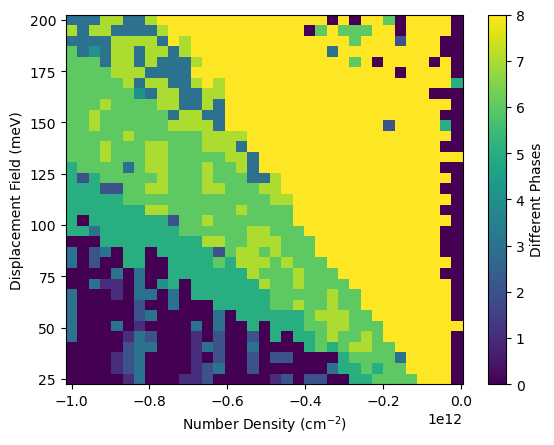

In [9]:
plt.colorbar(plt.pcolormesh(-total_number,v,labeled_states),label='Different Phases')
plt.xlabel(r'Number Density (cm$^{-2}$)');
plt.ylabel(r'Displacement Field (meV)');

## Nematicity

A nematic state will break the $C_3$ symmetry present in the noninteracting Fermi surfaces of BBG. To measure if such a symmetry breaking occurs, I calculate the first cosine Fourier coefficient of the order parameter, then takes its ratio with the constant part. If the ratio is larger that .1, the $C_3$ symmetry is considered to be broken, and the state is nematic.

In [10]:
cos = np.nan_to_num(momenta[:,0]/np.linalg.norm(momenta,axis=-1));
total_int = np.abs(np.sum((true_d),axis=-1)*(momenta[1,0]-momenta[0,0])*((momenta[1,1]-momenta[0,1])))
total_int[total_int==0] = 1
nem = np.abs(np.sum((true_d*cos),axis=-1)*(momenta[1,0]-momenta[0,0])*((momenta[1,1]-momenta[0,1])))/total_int

/var/folders/1q/zp3790g13xl1ng295qgnlfdm0000gn/T/ipykernel_81041/702056784.py:1: RuntimeWarning: invalid value encountered in divide
  cos = np.nan_to_num(momenta[:,0]/np.linalg.norm(momenta,axis=-1));


I can then plot the Fermi surfaces of these nematic states to confirm they are not $C_3$ symmetric.

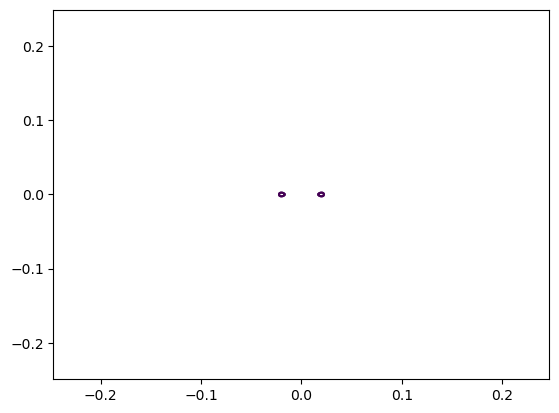

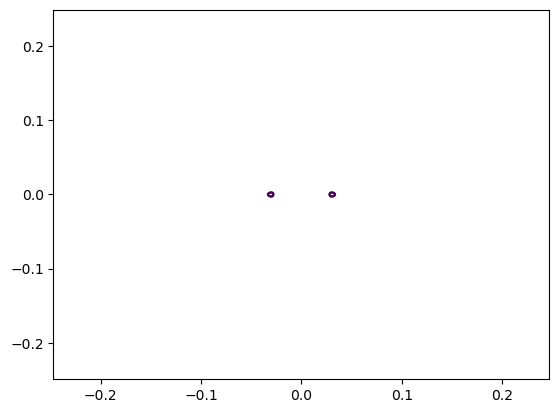

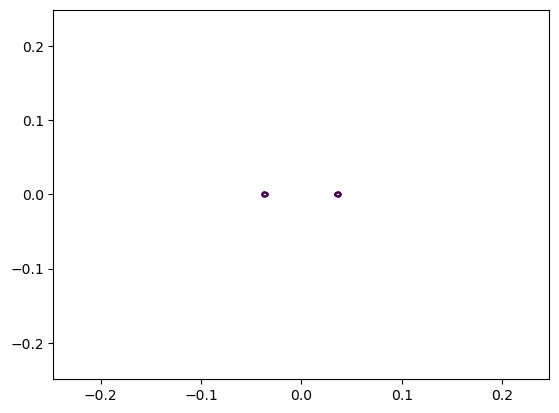

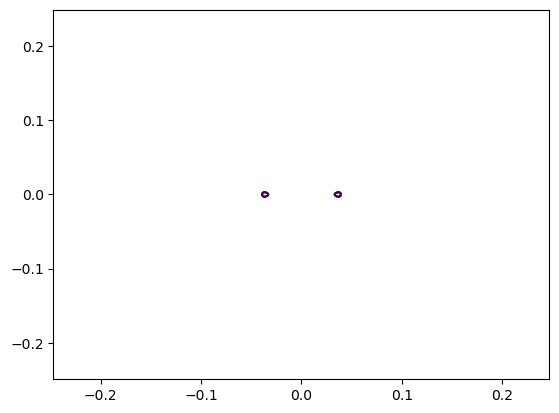

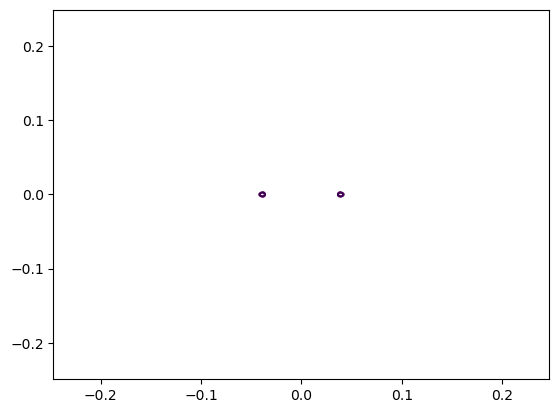

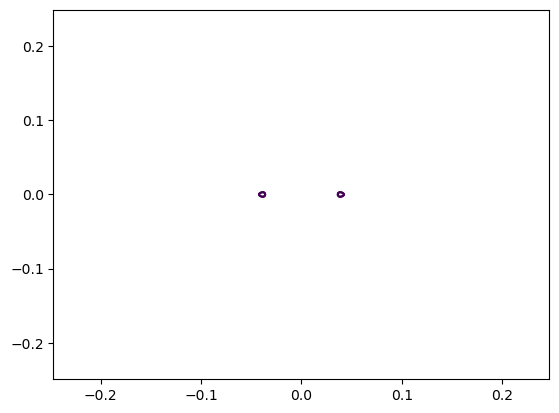

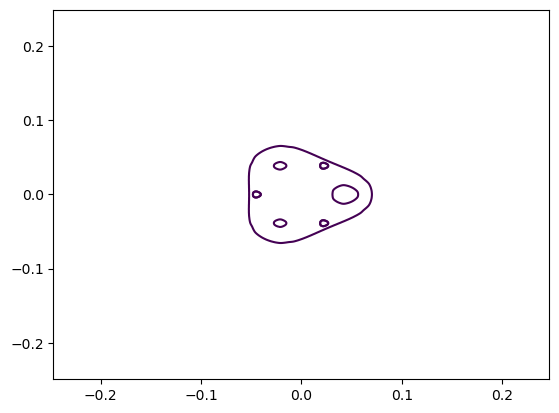

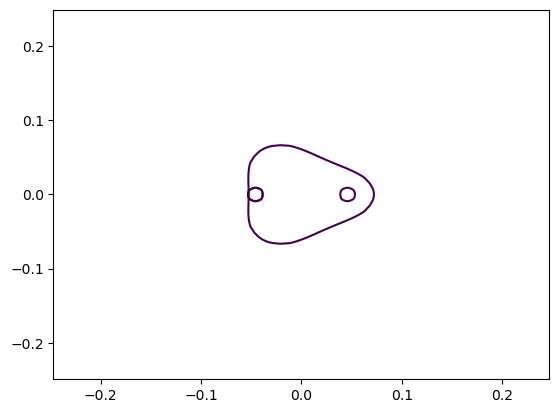

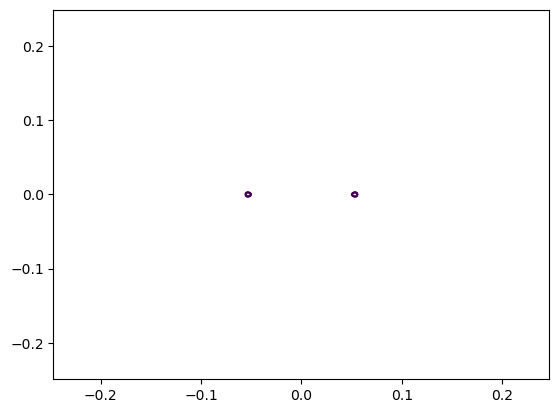

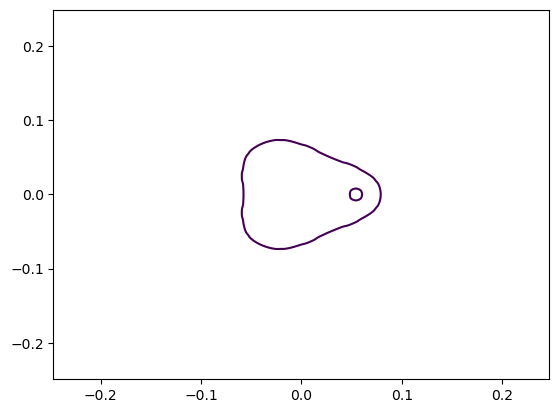

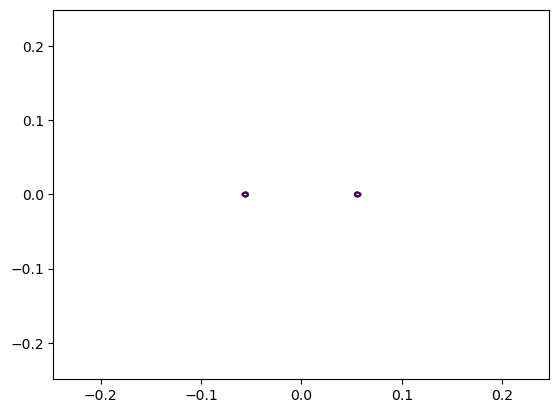

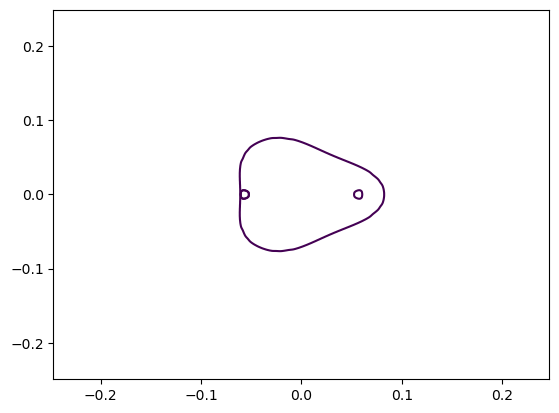

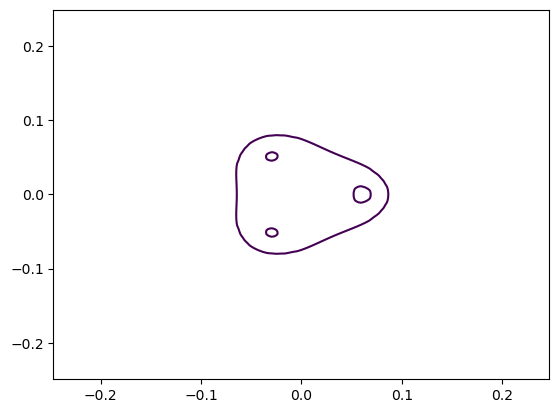

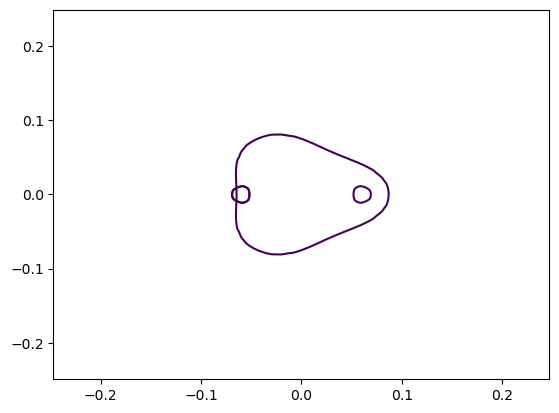

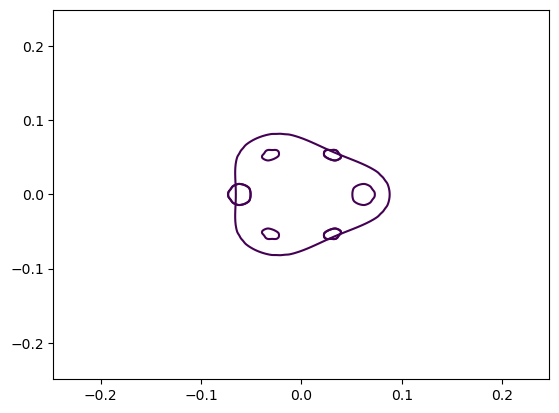

In [11]:
grid_x = np.linspace(kx.min(), kx.max(), 400)
grid_y = np.linspace(ky.min(), ky.max(), 400)
X, Y = np.meshgrid(grid_x, grid_y)

indices = np.unique(np.array([np.where(nem>.1)[0],np.where(nem>.1)[1]]).T,axis=0)

for index in indices:
    plt.figure()
    for e,x in zip(energy[:,index[0]],true_d[index[0],index[1]]):
        Z = griddata((kx, ky), e-x, (X, Y), method='cubic')
        plt.contour(X,Y,Z,[true_ef[index[0],index[1]]])

I can now plot where these nematic states occur on the same phase diagrams as before.

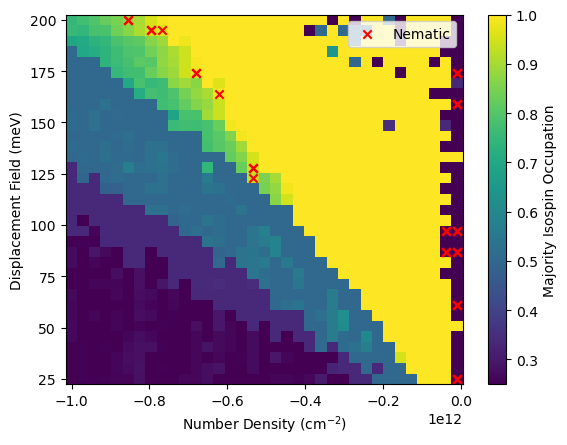

In [12]:
plt.colorbar(plt.pcolormesh(-total_number,v,np.sort(true_occupation)[:,:,-1]),label='Majority Isospin Occupation')
plt.xlabel(r'Number Density (cm$^{-2}$)');
plt.ylabel(r'Displacement Field (meV)');
plt.scatter(-total_number[np.where(nem>.1)[1]],v[np.where(nem>.1)[0]],marker='x',color='red',label='Nematic')
plt.legend();

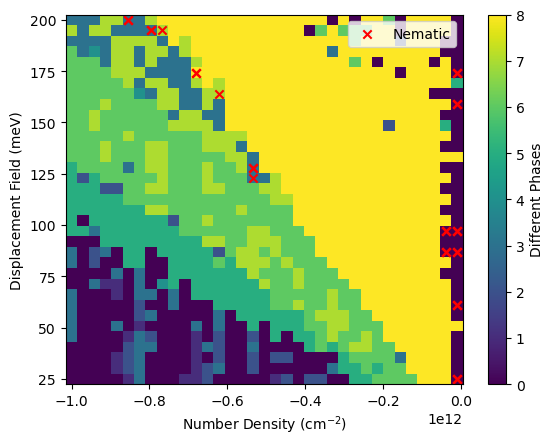

In [13]:
plt.colorbar(plt.pcolormesh(-total_number,v,labeled_states),label='Different Phases')
plt.xlabel(r'Number Density (cm$^{-2}$)');
plt.ylabel(r'Displacement Field (meV)');
plt.scatter(-total_number[np.where(nem>.1)[1]],v[np.where(nem>.1)[0]],marker='x',color='red',label='Nematic')
plt.legend();